# Performance of different algorithms

In [72]:
import dill
dill.dump_session('../Data/notebook_log_30.db')

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/Trong/Personal/Thesis2023-TrongCuong/Code'

In [2]:
%%time
from Bandits import *
from Evaluator import evaluate
import Dataset
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
random.seed(42)
np.random.seed(42)

CPU times: user 2 s, sys: 844 ms, total: 2.84 s
Wall time: 4.22 s


In [3]:
%%time
files = ("/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090503",
         "/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090504",
         "/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090505",
         "/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090506",
         "/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090507",
         "/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090508",
         "/Users/Trong/Personal/Thesis2023-TrongCuong/zip/ydata-fp-td-clicks-v1_0.20090509")

Dataset.get_yahoo_events(files)

33680074 events with 199 articles
CPU times: user 27min 2s, sys: 1min 30s, total: 28min 33s
Wall time: 29min 51s


In [4]:
#Get CRT base for calculate CTF Lift.
sizes = [1, 5, 10, 20, 30, 100]
rnd_ctr = []
for size in sizes:
    learn_ctr, _ = evaluate(RandomPolicy(), size=size,learn_ratio=1)
    rnd_ctr.append(learn_ctr[-1])

Random policy       0.0345    22.9s
Random policy       0.0347    1.2m
Random policy       0.0361    2.1m
Random policy       0.0358    3.7m
Random policy       0.0355    5.8m
Random policy       0.0359    2.3m


In [5]:
#Get CTR of E-Greedy
parameters = [0.3, 0.1, 0.1, 0.1, 0.1, 0.1]
sizes = [1, 5, 10, 20, 30, 100]
assert len(parameters) == len(sizes)
egreedy_ctr = []
for i, size in enumerate(sizes):
    learn_ctr, _ = evaluate(Egreedy(parameters[i]), size=size,learn_ratio=1)
    egreedy_ctr.append(learn_ctr[-1])

Egreedy (ε=0.3)     0.0403    44.2s
Egreedy (ε=0.1)     0.0493    4.3m
Egreedy (ε=0.1)     0.0515    8.1m
Egreedy (ε=0.1)     0.0528    15.9m
Egreedy (ε=0.1)     0.0494    26.7m
Egreedy (ε=0.1)     0.0521    3.1m


In [6]:
results = [['Size','Algorithm','Relative CTR','CTR Lift']]

## LinUCB Hybrid 

In [10]:
sizes = [1, 5, 10, 20, 30, 100]
a_hybrid = [0.4, 0.4, 0.2, 0.2, 0.4, 0.4]
linucb_hybrid_100 = []

for i,size in enumerate(sizes):
    learn ,deploy = evaluate(LinUCB_Hybrid(a_hybrid[i], context="user"),size=size,learn_ratio= 1)
    results.append([size, "LinUCB Hybrid ", learn[-1]/rnd_ctr[i], (learn[-1]/egreedy_ctr[i] - 1) * 100 ] )
    if size == 100:
        linucb_hybrid_100 = learn

LinUCB Hybrid (α=0.4, context:user)0.0407    2.0m
LinUCB Hybrid (α=0.4, context:user)0.0486    8.4m
LinUCB Hybrid (α=0.2, context:user)0.0508    18.4m
LinUCB Hybrid (α=0.2, context:user)0.0509    35.6m
LinUCB Hybrid (α=0.4, context:user)0.0538    50.8m
LinUCB Hybrid (α=0.4, context:user)0.0578    96.5m


## Compare LinUCB (Disjoint) and LinUCB(Hybrid)

In [25]:
sizes = [1, 5, 10, 20, 30, 100]
a_disjoint = [0.8, 0.4, 0.2, 0.2, 0.2, 0.2]
linucb_disjoint_100 = []

for i,size in enumerate(sizes):
    learn ,deploy = evaluate(LinUCB(a_disjoint[i], context="user"),size=size,learn_ratio= 1)
    results.append([size, "LinUCB Disjoint", learn[-1]/rnd_ctr[i], (learn[-1]/egreedy_ctr[i] - 1) * 100 ] )
    if size == 100:
        linucb_disjoint_100 = learn

LinUCB Disjoint (α=0.8, context:user)0.0402    57.2s
LinUCB Disjoint (α=0.4, context:user)0.0475    5.2m
LinUCB Disjoint (α=0.2, context:user)0.053     9.5m
LinUCB Disjoint (α=0.2, context:user)0.053     17.4m
LinUCB Disjoint (α=0.2, context:user)0.0523    24.8m
LinUCB Disjoint (α=0.2, context:user)0.0565    14.7m


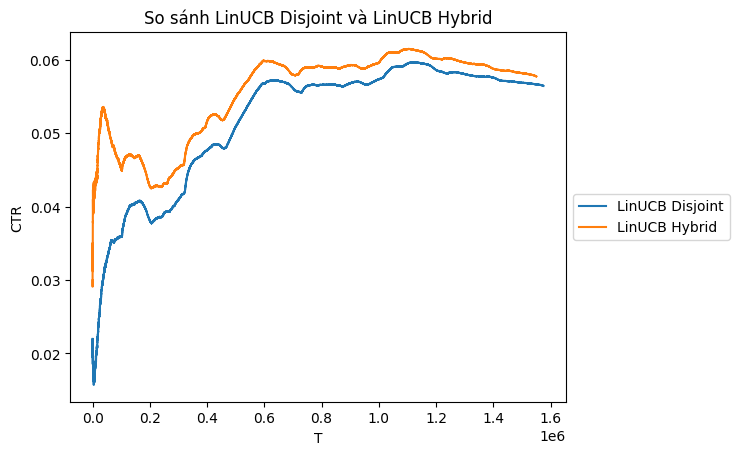

In [30]:
plt.plot(linucb_disjoint_100[1000:], label= "LinUCB Disjoint")
plt.plot(linucb_hybrid_100[1000:], label= "LinUCB Hybrid")
plt.title("So sánh LinUCB Disjoint và LinUCB Hybrid")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

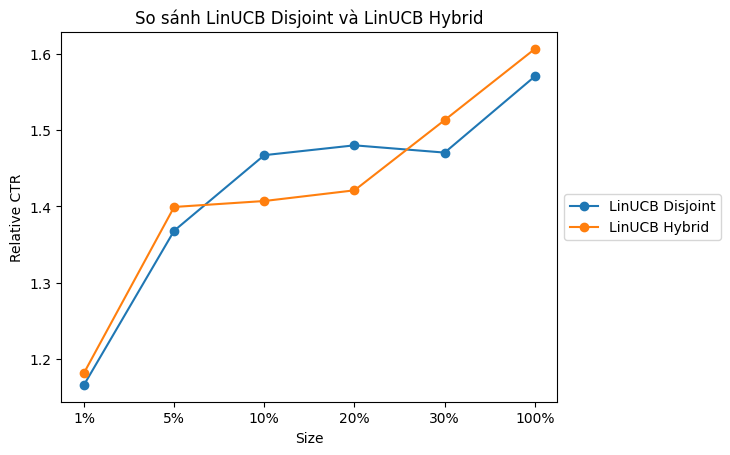

In [65]:
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:]

cat= ["1%","5%", "10%", "20%", "30%", "100%"]

value1 = df[df.Algorithm == "LinUCB Disjoint"].sort_values(["Size"])["Relative CTR"]
value2 = df[df.Algorithm == "LinUCB Hybrid "].sort_values(["Size"])["Relative CTR"]
# Vẽ cột đầu tiên
plt.plot(cat, value1, label = "LinUCB Disjoint", marker ="o")
# Vẽ cột thứ hai với vị trí dịch chuyển bằng giá trị bar_width
plt.plot(cat, value2, label = "LinUCB Hybrid", marker = "o")
# Đặt nhãn cho trục x và các vị trí
plt.xlabel('Size')
plt.ylabel('Relative CTR')
plt.title("So sánh LinUCB Disjoint và LinUCB Hybrid")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



## Compare LinUCB (Hybrid) and Linear Epsilon Greedy (Hybrid)

In [14]:
sizes = [1, 5, 10, 20, 30, 100]
e_hybrid = [0, 0, 0, 0.1, 0.1, 0.1]
egreedy_hybrid_100 = []

for i,size in enumerate(sizes):
    learn ,deploy = evaluate(Egreedy_Hybrid(e_hybrid[i], context="user"),size=size,learn_ratio= 1)
    results.append([size, "LinEGreedy Hybrid", learn[-1]/rnd_ctr[i], (learn[-1]/egreedy_ctr[i] - 1) * 100 ] )
    if size == 100:
        egreedy_hybrid_100 = learn

Egreedy Hybrid (ε=0), context:user)0.0336    1.7m
Egreedy Hybrid (ε=0), context:user)0.041     7.0m
Egreedy Hybrid (ε=0), context:user)0.0453    13.4m
Egreedy Hybrid (ε=0.1), context:user)0.0509    26.9m
Egreedy Hybrid (ε=0.1), context:user)0.0522    40.6m
Egreedy Hybrid (ε=0.1), context:user)0.0541    63.6m


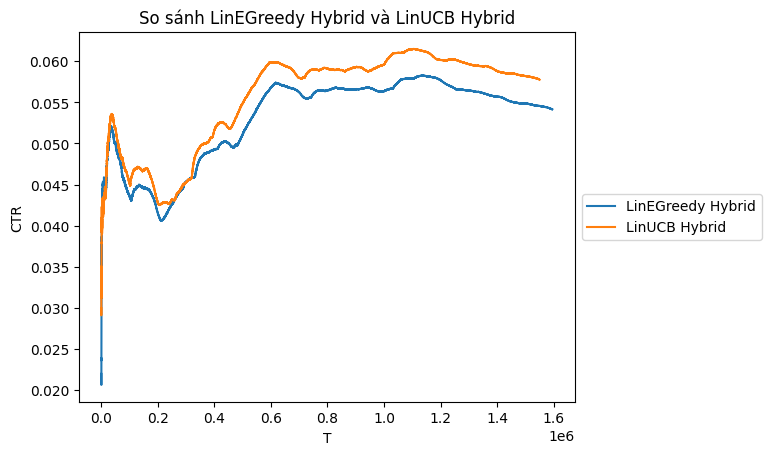

In [66]:
plt.plot(egreedy_hybrid_100[1000:], label= "LinEGreedy Hybrid")
plt.plot(linucb_hybrid_100[1000:], label= "LinUCB Hybrid")
plt.title("So sánh LinEGreedy Hybrid và LinUCB Hybrid")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


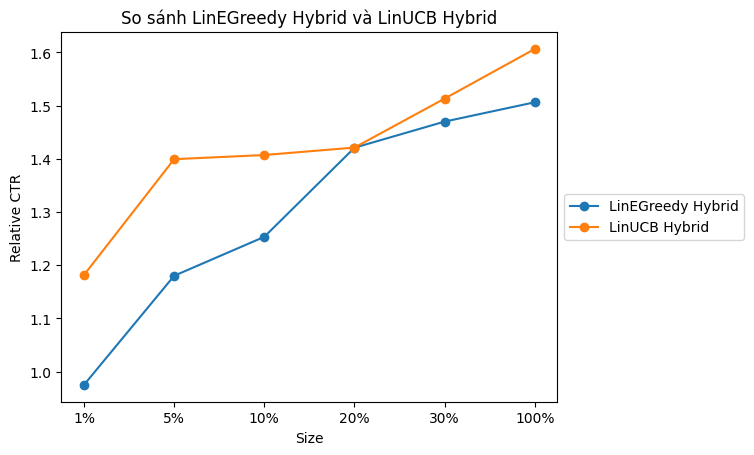

In [67]:
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:]

cat= ["1%", "5%", "10%", "20%", "30%", "100%"]

value1 = df[df.Algorithm == "LinEGreedy Hybrid"].sort_values(["Size"])["Relative CTR"]
value2 = df[df.Algorithm == "LinUCB Hybrid "].sort_values(["Size"])["Relative CTR"]
# Vẽ cột đầu tiên
plt.plot(cat, value1, label = "LinEGreedy Hybrid", marker ="o")
# Vẽ cột thứ hai với vị trí dịch chuyển bằng giá trị bar_width
plt.plot(cat, value2, label = "LinUCB Hybrid", marker = "o")
# Đặt nhãn cho trục x và các vị trí
plt.xlabel('Size')
plt.ylabel('Relative CTR')
plt.title('So sánh LinEGreedy Hybrid và LinUCB Hybrid')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



## Compare LinUCB Disjoint and Linear Epsilon Greedy Disjoint


In [22]:
sizes = [1, 5, 10, 20, 30, 100]
e_disjoint = [0.1, 0.1, 0.1, 0.1, 0.1, 0.2]
egreedy_disjoint_100 = []

for i,size in enumerate(sizes):
    learn ,deploy = evaluate(Egreedy_Disjoint(e_disjoint[i], context="user"),size=size,learn_ratio= 1)
    results.append([size, "LinEGreedy Disjoint", learn[-1]/rnd_ctr[i], (learn[-1]/egreedy_ctr[i] - 1) * 100 ] )
    if size == 100:
        egreedy_disjoint_100 = learn

Egreedy Disjoint (ε=0.1), context:user)0.0415    1.1m
Egreedy Disjoint (ε=0.1), context:user)0.0475    3.5m
Egreedy Disjoint (ε=0.1), context:user)0.0484    7.6m
Egreedy Disjoint (ε=0.1), context:user)0.0522    14.4m
Egreedy Disjoint (ε=0.1), context:user)0.0531    71.1m
Egreedy Disjoint (ε=0.2), context:user)0.0522    10.5m


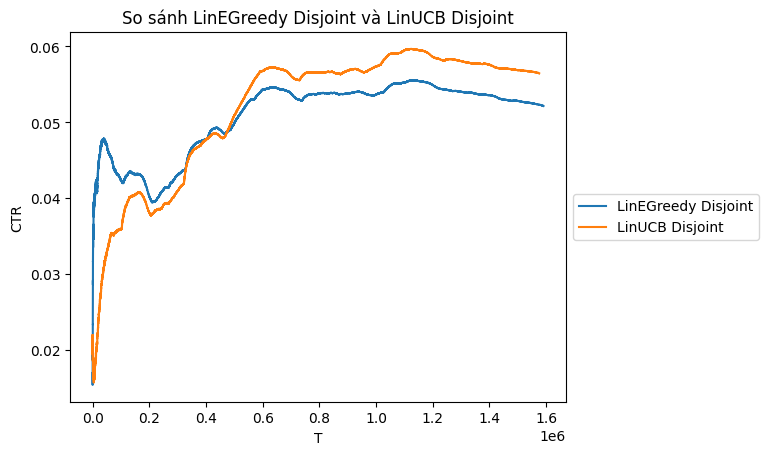

In [68]:
plt.plot(egreedy_disjoint_100[1000:], label= "LinEGreedy Disjoint")
plt.plot(linucb_disjoint_100[1000:], label= "LinUCB Disjoint")
plt.title("So sánh LinEGreedy Disjoint và LinUCB Disjoint")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


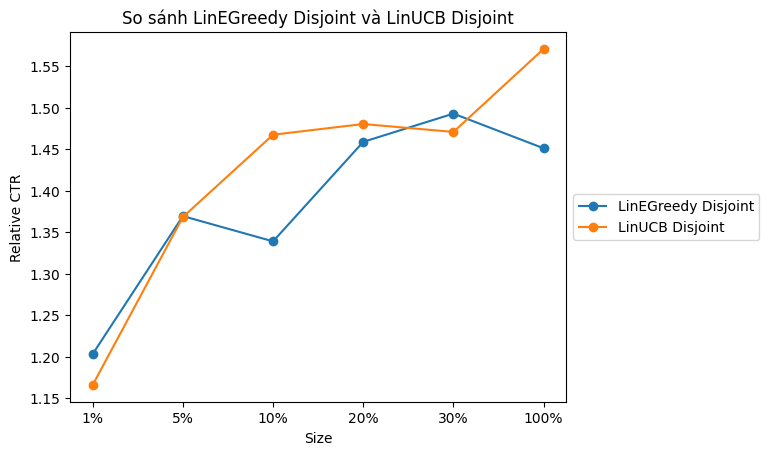

In [69]:
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:]

cat= ["1%","5%", "10%", "20%", "30%", "100%"]

value1 = df[df.Algorithm == "LinEGreedy Disjoint"].sort_values(["Size"])["Relative CTR"]
value2 = df[df.Algorithm == "LinUCB Disjoint"].sort_values(["Size"])["Relative CTR"]
# Vẽ cột đầu tiên
plt.plot(cat, value1, label = "LinEGreedy Disjoint", marker ="o")
# Vẽ cột thứ hai với vị trí dịch chuyển bằng giá trị bar_width
plt.plot(cat, value2, label = "LinUCB Disjoint", marker = "o")
# Đặt nhãn cho trục x và các vị trí
plt.xlabel('Size')
plt.ylabel('Relative CTR')
plt.title('So sánh LinEGreedy Disjoint và LinUCB Disjoint')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Compare LinUCB (Hybrid) and UCB

In [37]:
sizes = [1, 5, 10, 20, 30, 100]
alpha = [0, 0, 0, 0, 0.2, 0.2]
ucb_100 = []

for i,size in enumerate(sizes):
    learn ,deploy = evaluate(Ucb1(alpha[i]),size=size,learn_ratio= 1)
    results.append([size, "UCB", learn[-1]/rnd_ctr[i], (learn[-1]/egreedy_ctr[i] - 1) * 100 ] )
    if size == 100:
        ucb_100 = learn

UCB1 (a=0)          0.0292    1.1m
UCB1 (a=0)          0.0287    3.8m
UCB1 (a=0)          0.0306    7.5m
UCB1 (a=0)          0.0302    16.6m
UCB1 (a=0.2)        0.0479    22.8m
UCB1 (a=0.2)        0.0543    4.4m


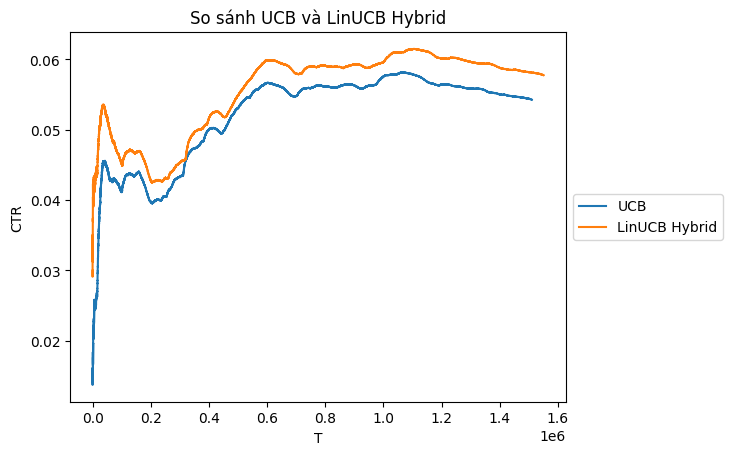

In [70]:
plt.plot(ucb_100[1000:], label= "UCB")
plt.plot(linucb_hybrid_100[1000:], label= "LinUCB Hybrid")
plt.title("So sánh UCB và LinUCB Hybrid")
plt.xlabel("T")
plt.ylabel("CTR")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


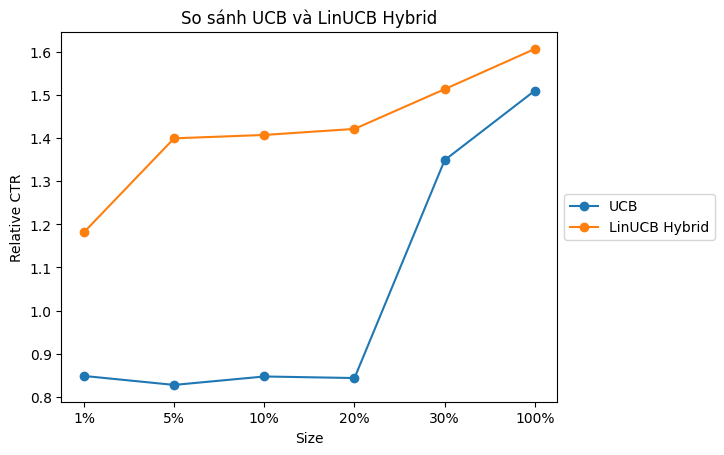

In [71]:
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:]

cat= ["1%","5%", "10%", "20%", "30%", "100%"]

value1 = df[df.Algorithm == "UCB"].sort_values(["Size"])["Relative CTR"]
value2 = df[df.Algorithm == "LinUCB Hybrid "].sort_values(["Size"])["Relative CTR"]
# Vẽ cột đầu tiên
plt.plot(cat, value1, label = "UCB", marker ="o")
# Vẽ cột thứ hai với vị trí dịch chuyển bằng giá trị bar_width
plt.plot(cat, value2, label = "LinUCB Hybrid", marker = "o")
# Đặt nhãn cho trục x và các vị trí
plt.xlabel('Size')
plt.ylabel('Relative CTR')
plt.title('So sánh UCB và LinUCB Hybrid')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [60]:
backup = results
backup

[['Size', 'Algorithm', 'Relative CTR', 'CTR Lift'],
 [1, 'LinEGreedy Hybrid', 1.0179061155797, -13.044591530450944],
 [5, 'LinEGreedy Hybrid', 1.2303339310814203, -13.430534357642154],
 [10, 'LinEGreedy Hybrid', 1.2670120982500168, -11.121369224721423],
 [20, 'LinEGreedy Hybrid', 1.3974121733130052, -5.26240133478888],
 [30, 'LinEGreedy Hybrid', 1.4663396491736742, 5.46179343431763],
 [100, 'LinEGreedy Hybrid', 1.4889717233502138, 2.696260440551179],
 [1, 'LinUCB Hybrid ', 1.1816172608717619, 0.9405582706991655],
 [5, 'LinUCB Hybrid ', 1.3993531611587082, -1.5379058106812393],
 [10, 'LinUCB Hybrid ', 1.4071678676795987, -1.289692874225512],
 [20, 'LinUCB Hybrid ', 1.421183525546277, -3.6508218233080814],
 [30, 'LinUCB Hybrid ', 1.5132958083436021, 8.838965129592014],
 [100, 'LinUCB Hybrid ', 1.6065979336919531, 10.809088738398653],
 [1, 'LinUCB Disjoint', 1.1432854879496939, -2.333962749249907],
 [5, 'LinUCB Disjoint', 0.8896001362863751, -37.4054421420458],
 [10, 'LinUCB Disjoint', 1.

In [64]:
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:]
df


,Size,Algorithm,Relative CTR,CTR Lift
1,1,LinUCB Hybrid,1.181617,0.940558
2,5,LinUCB Hybrid,1.399353,-1.537906
3,10,LinUCB Hybrid,1.407168,-1.289693
4,20,LinUCB Hybrid,1.421184,-3.650822
5,30,LinUCB Hybrid,1.513296,8.838965
6,100,LinUCB Hybrid,1.606598,10.809089
7,1,LinEGreedy Hybrid,0.975048,-16.705804
8,5,LinEGreedy Hybrid,1.180162,-16.960784
9,10,LinEGreedy Hybrid,1.253412,-12.075394
10,20,LinEGreedy Hybrid,1.420887,-3.670901
